In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import mylibrary.nnlib as tnn
import mylibrary.dynamicnnlib as tdnn

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

In [2]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

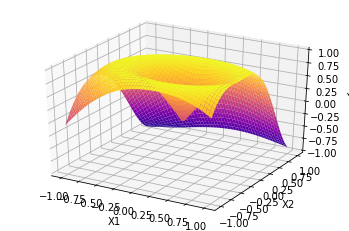

In [3]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

### Initial Network

In [4]:
optimizer = tnn.Adam(0.01)
dynet = tdnn.DynamicNN_Relu([2,3,1], optimizer)

In [5]:
total_new_neurons = 0

In [6]:
dynet

 2 == 3 == 1 ->
  \  / \  /
    1    1 

### Further Training/Adjustment

In [13]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

try:
    for epoch in range(100000):
        yout = dynet.forward(xx)
        dy = yout - yy
        dx = dynet.backward(dy)

        dynet.update()

        if epoch%100 == 0:
            error = tnn.MseLoss().loss(yout, yy)
            print(epoch, 'Error = ', error)
            ax.clear()

            ax.scatter(X1, X2, Y)
            ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_zlabel('Y')

            fig.canvas.draw()
            plt.pause(0.01)
    
except Exception as e:
    plt.close()
    if str(e) == 'invalid command name "."':
        print("Closing Tk Plot ")
    else:
        raise e

0 Error =  0.018235674619415738
100 Error =  0.009997755134444864
200 Error =  0.008471058718002245
300 Error =  0.008300373843444515
400 Error =  0.008903399882145488
500 Error =  0.008265287009339052
Closing Tk Plot 


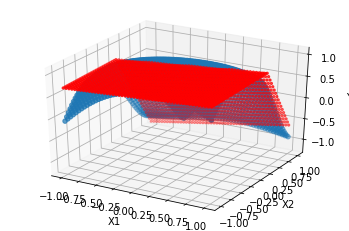

In [8]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
fig.canvas.draw()

In [9]:
dynet_backup = copy.deepcopy(dynet)
# dynet = copy.deepcopy(dynet_backup)

In [10]:
dynet

 2 == 3 == 1 ->
  \  / \  /
    1    1 

## Add Neurons to all possible layers

In [11]:
neurons_added = dynet.add_neurons_to_all_possible_layers()
total_new_neurons += neurons_added
neurons_added

3

In [12]:
dynet

 2 == 4 == 1 ->
  \  / \  /
    2    2 

## Remove/Decay Shortcut connection (Residual Layer becomes new Layer)

In [20]:
dynet.start_decaying_removable_shortcut_connections(decay_steps=1000)

In [21]:
dynet.removable_layers

[1]

In [22]:
dynet

 2 == 4 == 1 ->
  \  / \  /
    2    2 

## Compute Neuron Significance and decay less significant ones

In [14]:
dynet.compute_neuron_significance(xx)

In [15]:
dynet.significance

[array([[0.2163344 , 0.        , 0.91881994, 0.66640554]])]

In [16]:
dynet.significance_res

[array([[1.        , 0.48073015]]), array([[1., 0.]])]

In [39]:
num_neurons_remove = total_new_neurons//2
dynet.start_decaying_less_significant_neurons(num_neurons_remove, 0.1, 1000)
total_new_neurons = 0
num_neurons_remove

4

In [40]:
dynet.decay, dynet.decay_res

({0: array([3]), 1: array([1, 2])}, {1: array([1])})

In [70]:
dynet

 2 == 4 == 2 == 1 ->
  \  / \  / \  /
    2    1    1 

## Construction of NN for Spiral Dataset

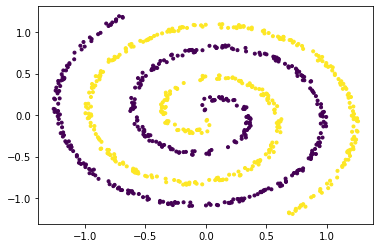

In [6]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

x, y = twospirals(400)
x, y = x/10, y.reshape(-1)
xx, yy = np.array(x), np.reshape(y, (-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.scatter(x1, x2, c=y, marker='.')
plt.show()

In [81]:
optimizer = tnn.Adam(0.01)
dynet = tdnn.DynamicNN_Relu([2,1], optimizer)
sigmoid = tnn.Sigmoid()

In [82]:
dynet

 2 == 1 ->
  \  /
    1 

In [138]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

try:
    for epoch in range(100000):
        yout = sigmoid.forward(dynet.forward(xx))
        
        dy = tnn.CrossEntropyBinary().del_loss(yout, yy)
        dx = dynet.backward(sigmoid.backward(dy))

        dynet.update()

        if epoch%100 == 0:
            error = tnn.CrossEntropyBinary().loss(yout, yy)
            print(epoch, 'Error = ', error)
            ax.clear()
            
#             out = (yout>0.5).reshape(-1)
            out = yout
            ax.scatter(x1, x2, c=out, marker='.')

            fig.canvas.draw()
            plt.pause(0.01)
    
except Exception as e:
    plt.close()
    if str(e).startswith('invalid command name'):
        print("Closing Tk Plot ")
    else:
        raise e

0 Error =  3.6504414966972747
100 Error =  3.655410573176852
200 Error =  3.6591809248424045
300 Error =  3.6617904102748238
400 Error =  3.6636601642486637
500 Error =  3.664732932211383
600 Error =  3.6655373215967004
700 Error =  3.665751602731136
800 Error =  3.663619898418801
900 Error =  4.279180064452558
1000 Error =  2.0128270049243024
1100 Error =  1.8537385415282
1200 Error =  1.6059750096979528
1300 Error =  1.5402160564047793
1400 Error =  1.5374668643159426
1500 Error =  1.5381005543173094
1600 Error =  1.5401538909920427
1700 Error =  1.5418752287888395
1800 Error =  1.5436097623394835
1900 Error =  1.5444081616592955
2000 Error =  1.5448549791356112
2100 Error =  1.5447734971087888
2200 Error =  1.5450230274474694
2300 Error =  1.5452609574174534
2400 Error =  1.5453295921390862
2500 Error =  1.5453760869348268
Closing Tk Plot 


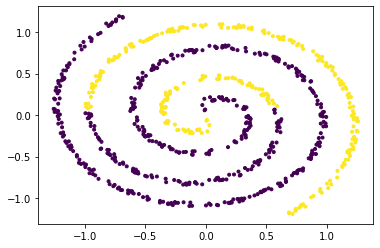

In [134]:
%matplotlib inline
yout = sigmoid.forward(dynet.forward(xx))
out = (yout>0.5).reshape(-1)

plt.scatter(x1, x2, c=out, marker='.')

In [118]:
####

In [127]:
neurons_added = dynet.add_neurons_to_all_possible_layers()
neurons_added

9

In [128]:
####

In [135]:
dynet.start_decaying_removable_shortcut_connections(decay_steps=1000)
dynet.removable_layers

[]

In [43]:
####

In [139]:
dynet.compute_neuron_significance(xx)
dynet.significance, dynet.significance_res

([array([[  1.        , 535.69310834,  96.81419973, 281.0392343 ]]),
  array([[  1.        , 202.40670096, 159.64241984, 195.93461842,
           58.5720373 ,  62.04262192]]),
  array([[ 1.        ,  1.03372134, 43.82418641, 66.20296602, 41.27578459,
          21.29608231, 12.32102208,  0.        ]]),
  array([[ 1.        , 33.06097034,  4.96895699, 17.46339195,  6.93101078,
           6.35931333]]),
  array([[ 1.        ,  0.        , 10.21388867, 15.11554977]]),
  array([[ 1.        , 15.64791037, 24.33941861]])],
 [array([[1.]]),
  array([[1.]]),
  array([[ 1.        , 83.43964844,  2.47939097]]),
  array([[ 1.        , 13.87179385,  0.04581213]]),
  array([[ 1.        , 20.9123011 ,  6.67770294]]),
  array([[1.]]),
  array([[1.]])])

In [140]:
dynet.start_decaying_less_significant_neurons(neurons_added//2, 0.1, 1000)
dynet.decay, dynet.decay_res

({2: array([7]), 4: array([1])}, {3: array([2])})